In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf

# 11. Training Deep Neural Networks
In `Chapter 10` we introduced artificial neural networks and trained our first deep neural networks. But they were shallow nets, with just a few hidden layers. What if you need to tackle a complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper `DNN`, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. Training a deep `DNN` isn’t a walk in the park. Here are some of the problems you could run into:

+ You may be faced with the tricky vanishing gradients problem or the related exploding gradients problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the `DNN` during training. Both of these problems make lower layers very hard to train.

+ You might not have enough training data for such a large network, or it might be too costly to label.

+ Training may be extremely slow.

+ A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

In this chapter we will go through each of these problems and present techniques to solve them. We will start by exploring the vanishing and exploding gradients problems and some of their most popular solutions. Next, we will look at transfer learning and unsupervised pretraining, which can help you tackle complex tasks even when you have little labeled data. Then we will discuss various optimizers that can speed up training large models tremendously. Finally, we will go through a few popular regularization techniques for large neural networks.

With these tools, you will be able to train very deep nets. Welcome to Deep Learning!

## 11.1 The Vanishing/Exploding Gradients Problems
As we discussed in `Chapter 10`, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a `Gradient Descent` step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the` Gradient Descent` update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the *vanishing gradients problem*. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the *exploding gradients problem*, which surfaces in recurrent neural networks (see `Chapter 15`). More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a `DNN`, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio. The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

Looking at the logistic activation function (see `Figure 11-1`), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

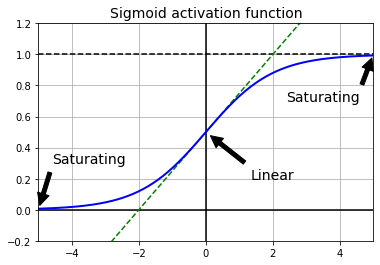

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

### 11.1.1 Glorot and He Initialization
In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction (please check out the paper if you are interested in the mathematical details). It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in `Equation 11-1`, where $\text{fan}_{avg} = \displaystyle\frac{(\text{fan}_{in}+\text{fan}_{out})}{2}$. This initialization strategy is called `Xavier initialization` or `Glorot initialization`, after the paper’s first author.

<img src="images/e_11_01.png" style="width:500px;"/>

If you replace $\text{fan}_{avg}$ with $\text{fan}_{in}$ in `Equation 11-1`, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it `LeCun initialization`. Genevieve Orr and Klaus-Robert Müller even recommended it in their 1998 book `<<Neural Networks: Tricks of the Trade (Springer)>>`. `LeCun initialization` is equivalent to `Glorot initialization` when $\text{fan}_{in} = \text{fan}_{out}$. It took over a decade for researchers to realize how important this trick is. Using `Glorot initialization` can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning.

Some papers have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $\text{fan}_{avg}$ or $\text{fan}_{in}$, as shown in `Table 11-1` (for the uniform distribution, just compute $r = \sqrt{3\sigma^{2}}$). The initialization strategy for the `ReLU activation` function (and its variants, including the `ELU activation` described shortly) is sometimes called `He initialization`, after the paper’s first author. The `SELU activation` function will be explained later in this chapter. It should be used with `LeCun initialization` (preferably with a normal distribution, as we will see).

<img src="images/t_11_01.png" style="width:500px;"/>

By default, `Keras` uses `Glorot initialization` with a uniform distribution. When creating a layer, you can change this to `He initialization` by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` like this:

```python
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")
```

If you want `He initialization` with a uniform distribution but based on $\text{fan}_{avg}$ rather than $\text{fan}_{in}$ , you can use the `VarianceScaling` initializer like this:

```python
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)
```

In [3]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

### 11.1.2 Nonsaturating Activation Functions
One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—-in particular, the `ReLU activation` function, mostly because it does not saturate for positive values (and because it is fast to compute).

Unfortunately, the `ReLU activation` function is not perfect. It suffers from a problem known as the `dying ReLUs`: during training, some neurons effectively `die`, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and `Gradient Descent` does not affect it anymore because the gradient of the `ReLU` function is zero when its input is negative.

To solve this problem, you may want to use a variant of the `ReLU` function, such as the `leaky ReLU`. This function is defined as $\text{LeakyReLU}_{\alpha}(z) = \max(\alpha z, z)$ (see `Figure 11-2`). The hyperparameter $\alpha$ defines how much the function `leaks`: it is the slope of the function for $z < 0$ and is typically set to 0.01. This small slope ensures that `leaky ReLUs` never die; they can go into a long coma, but they have a chance to eventually wake up. A 2015 paper compared several variants of the `ReLU activation` function, and one of its conclusions was that the leaky variants always outperformed the strict `ReLU activation` function. In fact, setting $\alpha = 0.2$ (a huge leak) seemed to result in better performance than $\alpha = 0.01$ (a small leak). The paper also evaluated the `randomized leaky ReLU` (`RReLU`), where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. `RReLU` also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set). Finally, the paper evaluated the `parametric leaky ReLU` (`PReLU`), where $\alpha$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). `PReLU` was reported to strongly outperform `ReLU` on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

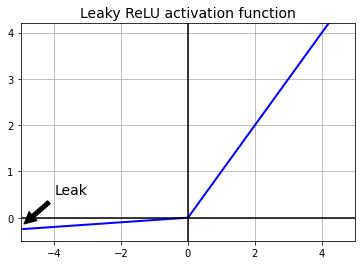

In [4]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [5]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Let's train a neural network on `Fashion MNIST` using the `Leaky ReLU`:

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

# 这里将lr从`1e-3`修改成`1e-2`
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6834 - accuracy: 0.7715 - val_loss: 0.5133 - val_accuracy: 0.8292
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4830 - accuracy: 0.8302 - val_loss: 0.4368 - val_accuracy: 0.8510
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4423 - accuracy: 0.8442 - val_loss: 0.5422 - val_accuracy: 0.7968
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4190 - accuracy: 0.8537 - val_loss: 0.4042 - val_accuracy: 0.8624
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4035 - accuracy: 0.8585 - val_loss: 0.3898 - val_accuracy: 0.8662
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3873 - accuracy: 0.8645 - val_loss: 0.3870 - val_accuracy: 0.8688
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3773 - accuracy: 0.8667 - val_loss: 0.3817 - val_accuracy:

Now let's try `PReLU`:

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

# 这里将lr从`1e-3`修改成`1e-2`
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6988 - accuracy: 0.7711 - val_loss: 0.5204 - val_accuracy: 0.8252
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4838 - accuracy: 0.8297 - val_loss: 0.4343 - val_accuracy: 0.8526
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4386 - accuracy: 0.8451 - val_loss: 0.5362 - val_accuracy: 0.7994
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4124 - accuracy: 0.8558 - val_loss: 0.3953 - val_accuracy: 0.8638
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3945 - accuracy: 0.8614 - val_loss: 0.3809 - val_accuracy: 0.8674
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3759 - accuracy: 0.8674 - val_loss: 0.3774 - val_accuracy: 0.8716
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3635 - accuracy: 0.8712 - val_loss: 0.3712 - val_accuracy:

Last but not least, a 2015 paper by Djork-Arné Clevert et al proposed a new activation function called the `exponential linear unit` (`ELU`) that outperformed all the `ReLU` variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set. `Figure 11-3` graphs the function, and `Equation 11-2` shows its definition.

<img src="images/11_03.png" style="width:600px;"/>

The `ELU activation` function looks a lot like the `ReLU` function, with a few major differences:
+ It takes on negative values when $z < 0$, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the value that the `ELU function` approaches when $z$ is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.

+ It has a nonzero gradient for $z < 0$, which avoids the dead neurons problem.

+ If $\alpha$ is equal to 1 then the function is smooth everywhere, including around $z = 0$, which helps speed up `Gradient Descent` since it does not bounce as much to the left and right of $z = 0$.

The main drawback of the `ELU activation` function is that it is slower to compute than the `ReLU function` and its variants (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an `ELU` network will be slower than a `ReLU` network.

Implementing `ELU` in `TensorFlow` is trivial, just specify the activation function when building each layer:

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal", activation="elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", activation="elu"),
    keras.layers.Dense(10, activation="softmax")
])

# 这里将lr从`1e-3`修改成`1e-2`
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6338 - accuracy: 0.7819 - val_loss: 0.4891 - val_accuracy: 0.8350
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4671 - accuracy: 0.8341 - val_loss: 0.4276 - val_accuracy: 0.8526
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4321 - accuracy: 0.8463 - val_loss: 0.5008 - val_accuracy: 0.8082
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4116 - accuracy: 0.8542 - val_loss: 0.4004 - val_accuracy: 0.8608
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3984 - accuracy: 0.8600 - val_loss: 0.3893 - val_accuracy: 0.8642
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3841 - accuracy: 0.8635 - val_loss: 0.3830 - val_accuracy: 0.8688
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3753 - accuracy: 0.8661 - val_loss: 0.3774 - val_accuracy:

Then, a 2017 paper by Günter Klambauer et al introduced the `Scaled ELU` (`SELU`) activation function: as its name suggests, it is a scaled variant of the `ELU activation` function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the `SELU activation` function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the `SELU activation` function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):

+ The input features must be standardized (mean 0 and standard deviation 1).

+ Every hidden layer’s weights must be initialized with LeCun normal initialization.

In Keras, this means setting `kernel_initializer="lecun_normal"`.

+ The network’s architecture must be sequential. Unfortunately, if you try to use `SELU` in nonsequential architectures, such as recurrent networks (see `Chapter 15`) or networks with skip connections (i.e., connections that skip layers, such as in `Wide & Deep nets`), self-normalization will not be guaranteed, so `SELU` will not necessarily outperform other activation functions.

+ The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the `SELU activation` function can improve performance in convolutional neural nets as well (see `Chapter 14`).

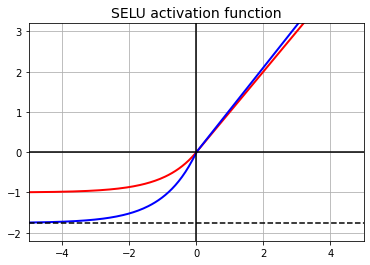

In [9]:
from scipy.special import erfc

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 
            + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, elu(z), "r-", linewidth=2)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

By default, the `SELU` hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [10]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Let's create a neural net for `Fashion MNIST` with 100 hidden layers, using the `SELU` activation function:

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

# 这里将lr从`1e-3`修改成`1e-2`
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [12]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 22s 13ms/step - loss: 1.0782 - accuracy: 0.5864 - val_loss: 0.8352 - val_accuracy: 0.6962
Epoch 2/20
1719/1719 [==============================] - 23s 13ms/step - loss: 0.6440 - accuracy: 0.7650 - val_loss: 0.5697 - val_accuracy: 0.7972
Epoch 3/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.5594 - accuracy: 0.7979 - val_loss: 0.6795 - val_accuracy: 0.7564
Epoch 4/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.6748 - accuracy: 0.7657 - val_loss: 0.5367 - val_accuracy: 0.8180
Epoch 5/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.5151 - accuracy: 0.8229 - val_loss: 0.4898 - val_accuracy: 0.8312
Epoch 6/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.4784 - accuracy: 0.8370 - val_loss: 0.4988 - val_accuracy: 0.8302
Epoch 7/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.4741 - accuracy: 0.8371 - val_loss: 0.4462 -

> **NOTES**
> 
> So, which activation function should you use for the hidden layers of your deep neural networks? Although your mileage will vary, in general `SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic`. If the network’s architecture prevents it from self-normalizing, then `ELU` may perform better than `SELU` (since `SELU` is not smooth at $z = 0$). If you care a lot about runtime latency, then you may prefer `leaky ReLU`. If you don’t want to tweak yet another hyperparameter, you may use the default $\alpha$ values used by `Keras` (e.g., 0.3 for `leaky ReLU`). If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as `RReLU` if your network is overfitting or `PReLU` if you have a huge training set. That said, because `ReLU` is the most used activation function (by far), many libraries and hardware accelerators provide `ReLU`-specific optimizations; therefore, if speed is your priority, `ReLU` might still be the best choice.

To use the `leaky ReLU activation` function, create a `LeakyReLU` layer and add it to your model just after the layer you want to apply it to:


```python
model = keras.models.Sequential([ 
    [...]
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2), 
    [...]
])
```

For `PReLU`, replace `LeakyRelu(alpha=0.2)` with `PReLU()`. There is currently no official implementation of `RReLU` in `Keras`, but you can fairly easily implement your own (to learn how to do that, see the exercises at the end of `Chapter 12`).

For `SELU activation`, set `activation="selu"` and `kernel_initializer="lecun_normal"` when creating a layer:

```python
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")
```

### 11.1.3 Batch Normalization
Although using `He initialization` along with `ELU` (or any variant of `ReLU`) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called `Batch Normalization` (`BN`) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a `BN` layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a `StandardScaler`); the `BN` layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name `Batch Normalization`). The whole operation is summarized step by step in `Equation 11-3`.

<img src="images/e_10_03.png" style="width:300px;"/>

In this algorithm:
+ $\mu_B$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).

+ $\sigma_B$ is the vector of input standard deviations, also evaluated over the whole minibatch (it contains one standard deviation per input).

+ $m_B$ is the number of instances in the mini-batch.

+ $\hat{x}^{(i)}$ is the vector of zero-centered and normalized inputs for instance i.

+ $\gamma$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

+ $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

+ $\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

+ $\epsilon$ is a tiny number that avoids division by zero (typically $10^{–5}$). This is called a smoothing term.

+ $z^{(i)}$ is the output of the `BN` operation. It is a rescaled and shifted version of the inputs.

So during training, `BN` standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the `BN` layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of `Batch Normalization` estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what `Keras` does automatically when you use the `BatchNormalization` layer. To sum up, four parameter vectors are learned in each batch-normalized layer: $\gamma$ (the output scale vector) and $\beta$ (the output offset vector) are learned through regular backpropagation, and $\mu$ (the final input mean vector) and $\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average. Note that $\mu$ and $\sigma$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in `Equation 11-3`).

Ioffe and Szegedy demonstrated that `Batch Normalization` considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the `ImageNet` classification task (`ImageNet` is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the `tanh` and even the `logistic` activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that:

> Applied to a state-of-the-art image classification model, `Batch Normalization` achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. […] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.

Finally, like a gift that keeps on giving, `Batch Normalization` acts like a regularizer, reducing the need for other regularization techniques (such as `dropout`, described later in this chapter).

`Batch Normalization` does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it’s often possible to fuse the `BN` layer with the previous layer, after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes $XW + b$, then the `BN` layer will compute $\gamma \otimes (XW + b – \mu)/\sigma + \beta$ (ignoring the smoothing term $\epsilon$ in the denominator). If we define $W′ = \gamma\otimes W/\sigma$ and $b′ = \gamma\otimes(b – \mu)/\sigma + \beta$, the equation simplifies to $XW′ + b′$. So if we replace the previous layer’s weights and biases ($W$ and $b$) with the updated weights and biases ($W′$ and $b′$), we can get rid of the `BN` layer (`TFLite`’s optimizer does this automatically; see `Chapter 19`).

> You may find that training is rather slow, because each epoch takes much more time when you use `Batch Normalization`. This is usually counterbalanced by the fact that convergence is much faster with `BN`, so it will take fewer epochs to reach the same performance. All in all, wall time will usually be shorter (this is the time measured by the clock on your wall).

##### Implementing Batch Normalization with Keras
As with most things with `Keras`, implementing `Batch Normalization` is simple and intuitive. Just add a `BatchNormalization` layer before or after each hidden layer’s activation function, and optionally add a `BN` layer as well as the first layer in your model. For example, this model applies `BN` after every hidden layer and as the first layer in the model (after flattening the input images):

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

That’s all! In this tiny example with just two hidden layers, it’s unlikely that `Batch Normalization` will have a very positive impact; but for deeper networks it can make a tremendous difference.

Let’s display the model summary:

In [14]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_110 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_111 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_112 (Dense)            (None, 10)               

As you can see, each `BN` layer adds four parameters per input: $\gamma$, $\beta$, $\mu$, and $\sigma$ (for example, the first `BN` layer adds 3136 parameters, which is 4 × 784). The last two parameters, $\mu$ and $\sigma$, are the moving averages; they are not affected by backpropagation, so `Keras` calls them “non-trainable”  (if you count the total number of BN parameters, 3136 + 1200 + 400, and divide by 2, you get 2368, which is the total number of non-trainable parameters in this model).

Let’s look at the parameters of the first `BN` layer. Two are trainable (by backpropagation), and two are not:

In [15]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Now when you create a `BN` layer in `Keras`, it also creates two operations that will be called by `Keras` at each iteration during training. These operations will update the moving averages. Since we are using the `TensorFlow` backend, these operations are `TensorFlow` operations (we will discuss `TF` operations in `Chapter 12`):

In [16]:
model.layers[1].updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

The authors of the `BN` paper argued in favor of adding the `BN` layers before the activation functions, rather than after (as we just did). There is some debate about this, as which is preferable seems to depend on the task—you can experiment with this too to see which option works best on your dataset. To add the `BN` layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the `BN` layers. Moreover, since a `Batch Normalization` layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass `use_bias=False` when creating it):

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(), keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(), keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9111 - accuracy: 0.6995 - val_loss: 0.6415 - val_accuracy: 0.7860
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6335 - accuracy: 0.7845 - val_loss: 0.5540 - val_accuracy: 0.8138
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5750 - accuracy: 0.8020 - val_loss: 0.5138 - val_accuracy: 0.8260
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5379 - accuracy: 0.8151 - val_loss: 0.4887 - val_accuracy: 0.8346
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5135 - accuracy: 0.8222 - val_loss: 0.4712 - val_accuracy: 0.8416
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4978 - accuracy: 0.8259 - val_loss: 0.4569 - val_accuracy: 0.8452
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4853 - accuracy: 0.8331 - val_loss: 0.4454 - val_accuracy:

The `BatchNormalization` class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the momentum. This hyperparameter is used by the `BatchNormalization` layer when it updates the exponential moving averages; given a new value $v$ (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average $\widehat{\mathrm{v}}$ using the following equation:
$$\widehat{\mathrm{v}} \leftarrow \widehat{\mathrm{v}}\times\text{momentum} + \mathrm{v}\times(1−\text{momentum})$$

A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you want more 9s for larger datasets and smaller mini-batches).

Another important hyperparameter is `axis`: it determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes). When the input batch is 2D (i.e., the batch shape is `[batch size, features]`), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch. For example, the first `BN` layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features. If we move the first BN layer before the Flatten layer, then the input batches will be 3D, with shape `[batch size, height, width]`; therefore, the BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set `axis=[1, 2]`.

Notice that the `BN` layer does not perform the same computation during training and after training: it uses batch statistics during training and the “final” statistics after training (i.e., the final values of the moving averages). Let’s take a peek at the source code of this class to see how this is handled:

```python
class BatchNormalization(keras.layers.Layer):
    # [...] 
    def call(self, inputs, training=None):
        # [...]
```

The `call()` method is the one that performs the computations; as you can see, it has an extra training argument, which is set to `None` by default, but the `fit()` method sets to it to 1 during training. If you ever need to write a custom layer, and it must behave differently during training and testing, add a training argument to the `call()` method and use this argument in the method to decide what to compute (we will discuss custom layers in `Chapter 12`).

`BatchNormalization` has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that `BN` is added after every layer. But a recent paper by Hongyi Zhang et al may change this assumption: by using a novel fixed-update (`fixup`) weight initialization technique, the authors managed to train a very deep neural network (10000 layers!) without `BN`, achieving state-of-the-art performance on complex image classification tasks. As this is bleeding-edge research, however, you may want to wait for additional research to confirm this finding before you drop `Batch Normalization`.

### 11.1.4 Gradient Clipping
Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called `Gradient Clipping`. This technique is most often used in recurrent neural networks, as `Batch Normalization` is tricky to use in `RNN`s, as we will see in `Chapter 15`. For other types of networks, `BN` is usually sufficient.

In `Keras`, implementing `Gradient Clipping` is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer, like this:

```python
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)
```

This optimizer will clip every component of the gradient vector to a value between `–1.0` and `1.0`. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between `–1.0` and `1.0`. The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is `[0.9, 100.0]`, it points mostly in the direction of the second axis; but once you clip it by value, you get `[0.9, 1.0]`, which points roughly in the diagonal between the two axes. In practice, this approach works well. If you want to ensure that `Gradient Clipping` does not change the direction of the gradient vector, you should clip by norm by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its $\ell_2$ norm is greater than the threshold you picked. For example, if you set `clipnorm=1.0`, then the vector `[0.9, 100.0]` will be clipped to `[0.00899964, 0.9999595]`, preserving its orientation but almost eliminating the first component. If you observe that the gradients explode during training (you can track the size of the gradients using `TensorBoard`), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.

## 11.2 Reusing Pretrained Layers
It is generally not a good idea to train a very large `DNN` from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle (we will discuss how to find them in `Chapter 14`), then reuse the lower layers of this network. This technique is called `transfer learning`.

It will not only speed up training considerably, but also require significantly less training data.

Suppose you have access to a `DNN` that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a `DNN` to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network (see `Figure 11-4`).

<img src="images/11_04.png" style="width:600px;"/>

> If the input pictures of your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work best when the inputs have similar low-level features.

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

> The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, try keeping all the hidden layers and just replacing the output layer.

Try freezing all the reused layers first (i.e., make their weights non-trainable so that `Gradient Descent` won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

### 11.2.1 Transfer Learning with Keras
Let’s look at an example. Suppose the `Fashion MNIST` dataset only contained eight classes—for example, all the classes except for sandal and shirt. Someone built and trained a `Keras` model on that set and got reasonably good performance (`>90%` accuracy). Let’s call this model `A`. You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (`positive=shirt, negative=sandal`). Your dataset is quite small; you only have 200 labeled images. When you train a new model for this task (let’s call it model `B`) with the same architecture as model `A`, it performs reasonably well (`97.2%` accuracy). But since it’s a much easier task (there are just two classes), you were hoping for more. While drinking your morning coffee, you realize that your task is quite similar to task `A`, so perhaps transfer learning can help? Let’s find out!

First, you need to load model `A` and create a new model based on that model’s layers. Let's split the fashion MNIST training set in two:
+ **X_train_A**: all images of all items except for sandals and shirts (classes 5 and 6).
+ **X_train_B**: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.
We will train a model on set `A` (classification task with 8 classes), and try to reuse it to tackle set `B` (binary classification). We hope to transfer a little bit of knowledge from task `A` to task `B`, since classes in set `A` (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set `B` (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the `CNN` chapter).

In [18]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A), (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

X_train_A.shape, X_train_B.shape

((43986, 28, 28), (200, 28, 28))

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8672
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3287 - val_accuracy: 0.8822
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3012 - val_accuracy: 0.8984
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2973 - accuracy: 0.8973 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2774 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2729 - accuracy: 0.9062 - val_loss: 0.2732 - val_accuracy: 0.9073
Epoch 7/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2720 - val_accuracy:

In [20]:
model_A.save("./models/my_model_A.h5")

Let's train model `B`:

In [21]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 28ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [22]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

Let’s reuse all the layers except for the output layer:

In [23]:
model_A = keras.models.load_model("./models/my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_A` and `model_B_on_A` now share some layers. When you train `model_B_on_A`, it will also affect `model_A`. If you want to avoid that, you need to clone `model_A` before you reuse its layers. To do this, you clone model `A`’s architecture with `clone_model()`, then copy its weights (since `clone_model()` does not clone the weights):

In [24]:
model_A_clone = keras.models.clone_model(model_A) 
model_A_clone.set_weights(model_A.get_weights())

Now you could train `model_B_on_A` for task `B`, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s trainable attribute to `False` and compile the model:

In [25]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

> You must always compile your model after you freeze or unfreeze layers.

Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task `B`. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [26]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=10, validation_data=(X_valid_B, y_valid_B))

Epoch 1/10
7/7 [==============================] - 0s 27ms/step - loss: 0.4685 - accuracy: 0.7450 - val_loss: 0.3584 - val_accuracy: 0.8448
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 0.2769 - accuracy: 0.9400 - val_loss: 0.2361 - val_accuracy: 0.9412
Epoch 3/10
7/7 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.9650 - val_loss: 0.1780 - val_accuracy: 0.9655
Epoch 4/10
7/7 [==============================] - 0s 13ms/step - loss: 0.1372 - accuracy: 0.9850 - val_loss: 0.1452 - val_accuracy: 0.9828
Epoch 5/10
7/7 [==============================] - 0s 12ms/step - loss: 0.1103 - accuracy: 0.9900 - val_loss: 0.1233 - val_accuracy: 0.9848
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 0.0922 - accuracy: 0.9950 - val_loss: 0.1084 - val_accuracy: 0.9888
Epoch 7/10
7/7 [==============================] - 0s 12ms/step - loss: 0.0795 - accuracy: 0.9950 - val_loss: 0.0975 - val_accuracy: 0.9888
Epoch 8/10
7/7 [===========

In [27]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=1e-4) # the default lr is 1e-2
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 27ms/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.9909
Epoch 2/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0532 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.9909
Epoch 3/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0528 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.9909
Epoch 4/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.9909
Epoch 5/16
7/7 [==============================] - 0s 13ms/step - loss: 0.0521 - accuracy: 1.0000 - val_loss: 0.0747 - val_accuracy: 0.9909
Epoch 6/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0517 - accuracy: 1.0000 - val_loss: 0.0743 - val_accuracy: 0.9909
Epoch 7/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0513 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.9909
Epoch 8/16
7/7 [===========

So, what’s the final verdict? Well, this model’s test accuracy is `99.25%`, which means that transfer learning reduced the error rate from `2.8%` down to almost `0.7%`! That’s a factor of four!

In [28]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9930


[0.06585733592510223, 0.9929999709129333]

Are you convinced? You shouldn’t be: I cheated! I tried many configurations until I found one that demonstrated a strong improvement. If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. What I did is called “torturing the data until it confesses.” When a paper just looks too positive, you should be suspicious: perhaps the flashy new technique does not actually help much (in fact, it may even degrade performance), but the authors tried many variants and reported only the best results (which may be due to sheer luck), without mentioning how many failures they encountered on the way. Most of the time, this is not malicious at all, but it is part of the reason so many results in science can never be reproduced.

Why did I cheat? It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers). We will revisit transfer learning in `Chapter 14`, using the techniques we just discussed (and this time there will be no cheating, I promise!).


### 11.2.2 Unsupervised Pretraining
Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task. Don’t lose hope! First, you should try to gather more labeled training data, but if you can’t, you may still be able to perform unsupervised pretraining (see `Figure 11-5`). Indeed, it is often cheap to gather unlabeled training examples, but expensive to label them. If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an `autoencoder` or a `generative adversarial network` (see `Chapter 17`). Then you can reuse the lower layers of the `autoencoder` or the lower layers of the `GAN`’s discriminator, add the output layer for your task on top, and finetune the final network using supervised learning (i.e., with the labeled training examples).

It is this technique that Geoffrey Hinton and his team used in 2006 and which led to the revival of neural networks and the success of Deep Learning. Until 2010, unsupervised pretraining—typically with `restricted Boltzmann machines` (`RBM`s; see `Appendix E`)—was the norm for deep nets, and only after the vanishing gradients problem was alleviated did it become much more common to train `DNN`s purely using supervised learning. Unsupervised pretraining (today typically using `autoencoders` or `GAN`s rather than `RBM`s) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

Note that in the early days of Deep Learning it was difficult to train deep models, so people would use a technique called greedy layer-wise pretraining (depicted in `Figure 11-5`). They would first train an unsupervised model with a single layer, typically an `RBM`, then they would freeze that layer and add another one on top of it, then train the model again (effectively just training the new layer), then freeze the new layer and add another layer on top of it, train the model again, and so on. Nowadays, things are much simpler: people generally train the full unsupervised model in one shot (i.e., in `Figure 11-5`, just start directly at step three) and use `autoencoders` or `GAN`s rather than `RBM`s.

<img src="images/11_05.png" style="width:500px;"/>

### 11.2.3 Pretraining on an Auxiliary Task
If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual—clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. You could, however, gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person. Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data.

For `natural language processing` (`NLP`) applications, you can download a corpus of millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are (e.g., it should predict that the missing word in the sentence “What ___ you saying?” is probably “are” or “were”). If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data (we will discuss more pretraining tasks in `Chapter 15`).

Self-supervised learning is when you automatically generate the labels from the data itself, then you train a model on the resulting “labeled” dataset using supervised learning techniques. Since this approach requires no human labeling whatsoever, it is best classified as a form of unsupervised learning.

## 11.3 Faster Optimizers
Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): 
+ applying a good initialization strategy for the connection weights
+ using a good activation function
+ using `Batch Normalization`
+ reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning)

Another huge speed boost comes from using a faster optimizer than the regular `Gradient Descent` optimizer. In this section we will present the most popular algorithms: 
+ momentum optimization
+ Nesterov Accelerated Gradient
+ AdaGrad
+ RMSProp
+ Adam and Nadam optimization

### 11.3.1 Momentum Optimization
Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind momentum optimization, proposed by Boris Polyak in 1964. In contrast, regular `Gradient Descent` will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

Recall that `Gradient Descent` updates the weights $\theta$ by directly subtracting the gradient of the cost function $J(\theta)$ with regard to the weights ($\nabla\theta J(\theta)$) multiplied by the learning rate $\eta$. The equation is: $\theta\leftarrow\theta  - \eta\nabla\theta J(\theta)$. It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the `momentum vector` $m$ (multiplied by the learning rate $\eta$), and it updates the weights by adding this momentum vector (see `Equation 11-4`). In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the `momentum`, which must be set between `0` (high friction) and `1` (no friction). A typical momentum value is `0.9`.

<img src="images/e_11_04.png" style="width:500px;"/>

You can easily verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $\eta$ multiplied by $\frac{1}{1-\beta}$ (ignoring the sign). For example, if $\beta = 0.9$, then the terminal velocity is equal to 10 times the gradient times the learning rate, so momentum optimization ends up going 10 times faster than `Gradient Descent`! This allows momentum optimization to escape from plateaus much faster than `Gradient Descent`. We saw in `Chapter 4` that when the inputs have very different scales, the cost function will look like an elongated bowl (see `Figure 4-7`). `Gradient Descent` goes down the steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum). In deep neural networks that don’t use `Batch Normalization`, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.

> Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.

Implementing momentum optimization in `Keras` is a no-brainer: just use the `SGD` optimizer and set its momentum hyperparameter, then lie back and profit!

In [29]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular `Gradient Descent`.

### 11.3.2 Nesterov Accelerated Gradient
One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla momentum optimization. The `Nesterov Accelerated Gradient` (`NAG`) method, also known as `Nesterov momentum optimization`, measures the gradient of the cost function not at the local position $\theta$ but slightly ahead in the direction of the momentum, at $\theta+\beta m$ (see `Equation 11-5`).

<img src="images/e_11_05.png" style="width:500px;"/>

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in `Figure 11-6` (where $\nabla_1$ represents the gradient of the cost function measured at the starting point $\theta$, and $\nabla_2$ represents the gradient at the point located at $\theta+\beta m$).

As you can see, the Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and `NAG` ends up being significantly faster than regular momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, $\nabla_1$ continues to push farther across the valley, while $\nabla_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus `NAG` converges faster.

<img src="images/11_06.png" style="width:600px;"/>

`NAG` is generally faster than regular momentum optimization. To use it, simply set `nesterov=True` when creating the `SGD` optimizer:

In [30]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad
Consider the elongated bowl problem again: `Gradient Descent` starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The `AdaGrad` algorithm achieves this correction by scaling down the gradient vector along the steepest dimensions (see `Equation 11-6`).

<img src="images/e_11_06.png" style="width:500px;"/>

The first step accumulates the square of the gradients into the vector $s$ (recall that the $\otimes$ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i \leftarrow s_i+\big({\displaystyle\frac{\partial J(\theta)}{\partial\theta_i}}\big)^2$ for each element $s_i$ of the vector $s$; in other words, each $s_i$ accumulates the squares of the partial derivative of the cost function with regard to parameter $\theta_i$. If the cost function is steep along the $i_{th}$ dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to `Gradient Descent`, but with one big difference: the gradient vector is scaled down by a factor of $\sqrt{s+\varepsilon}$ (the $\oslash$ symbol represents the element-wise division, and $\varepsilon$ is a smoothing term to avoid division by zero, typically set to $10^{–10}$). This vectorized form is equivalent to simultaneously computing $\theta_i\leftarrow\theta_i-\partial J(\theta)/\partial\theta_i/\sqrt{s_i+\varepsilon}$ for all parameters $\theta_i$.

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum (see `Figure 11-7`). One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.

<img src="images/11_07.png" style="width:600px;"/>

`AdaGrad` frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though `Keras` has an `Adagrad optimizer`, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as `Linear Regression`, though). Still, understanding `AdaGrad` is helpful to grasp the other adaptive learning rate optimizers.

### 11.3.4 RMSProp
As we’ve seen, `AdaGrad` runs the risk of slowing down a bit too fast and never converging to the global optimum. The `RMSProp` algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step (see `Equation 11-7`).

<img src="images/e_11_07.png" style="width:500px;"/>

The decay rate $\beta$ is typically set to `0.9`. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

As you might expect, `Keras` has an `RMSprop` optimizer:

In [31]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

Note that the `rho` argument corresponds to $\beta$ in `Equation 11-7`. Except on very simple problems, this optimizer almost always performs much better than `AdaGrad`. In fact, it was the preferred optimization algorithm of many researchers until `Adam` optimization came around.

### 11.3.5 Adam and Nadam Optimization
`Adam`, which stands for adaptive moment estimation, combines the ideas of momentum optimization and `RMSProp`: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like `RMSProp`, it keeps track of an exponentially decaying average of past squared gradients (see `Equation 11-8`).

<img src="images/e_11_08.png" style="width:500px;"/>

In this equation, $t$ represents the iteration number (starting at 1).

If you just look at steps 1, 2, and 5, you will notice `Adam`’s close similarity to both momentum optimization and `RMSProp`. The only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just $1–\beta_1$ times the decaying sum). Steps 3 and 4 are somewhat of a technical detail: since $m$ and $s$ are initialized at 0, they will be biased toward 0 at the beginning of training, so these two steps will help boost $m$ and $s$ at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to `0.9`, while the scaling decay hyperparameter $\beta_2$ is often initialized to `0.999`. As earlier, the smoothing term $\varepsilon$ is usually initialized to a tiny number such as $10^{–7}$. These are the default values for the `Adam` class (to be precise, epsilon defaults to `None`, which tells `Keras` to use `keras.backend.epsilon()`, which defaults to $10^{–7}$; you can change it using `keras.backend.set_epsilon()`). Here is how to create an `Adam` optimizer using `Keras`:

In [32]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Since `Adam` is an adaptive learning rate algorithm (like `AdaGrad` and `RMSProp`), it requires less tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta = 0.001$, making `Adam` even easier to use than `Gradient Descent`.

> If you are starting to feel overwhelmed by all these different techniques and are wondering how to choose the right ones for your task, don’t worry: some practical guidelines are provided at the end of this chapter.

Finally, two variants of Adam are worth mentioning:

##### AdaMax
Notice that in step 2 of `Equation 11-8`, `Adam` accumulates the squares of the gradients in $s$ (with a greater weight for more recent gradients). In step 5, if we ignore $\varepsilon$ and steps 3 and 4 (which are technical details anyway), `Adam` scales down the parameter updates by the square root of $s$. In short, `Adam` scales down the parameter updates by the $\ell_2$ norm of the time-decayed gradients (recall that the $\ell_2$ norm is the square root of the sum of squares). `AdaMax`, introduced in the same paper as `Adam`, replaces the $\ell_2$ norm with the $\ell_\infty$ norm (a fancy way of saying the max). Specifically, it replaces step 2 in `Equation 11-8` with $s\leftarrow \max(\beta_2\mathrm{s}, \nabla_\theta J(\theta))$, it drops step 4, and in step 5 it scales down the gradient updates by a factor of $s$, which is just the max of the time-decayed gradients. In practice, this can make `AdaMax` more stable than `Adam`, but it really depends on the dataset,and in general `Adam` performs better. So, this is just one more optimizer you can try if you experience problems with `Adam` on some task.

```python
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
```

##### Nadam
`Nadam` optimization is `Adam` optimization plus the `Nesterov` trick, so it will often converge slightly faster than `Adam`. In his report introducing this technique, the researcher Timothy Dozat compares many different optimizers on various tasks and finds that `Nadam` generally outperforms `Adam` but is sometimes outperformed by `RMSProp`.

```python
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
```

> Adaptive optimization methods (including `RMSProp`, `Adam`, and `Nadam` optimization) are often great, converging fast to a good solution. However, a 2017 paper by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using plain `Nesterov Accelerated Gradient` instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, because it’s moving fast.

All the optimization techniques discussed so far only rely on the `first-order partial derivatives` (`Jacobians`). The optimization literature also contains amazing algorithms based on the `second-order partial derivatives` (the `Hessians`, which are the partial derivatives of the `Jacobians`). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are $n^2$ `Hessians` per output (where $n$ is the number of parameters), as opposed to just $n$ `Jacobians` per output. Since `DNN`s typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the `Hessians` is just too slow.

> **Training Sparse Models**
> 
> All the optimization algorithms just presented produce dense models, meaning that most parameters will be nonzero. If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead.
> 
> One easy way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to zero). Note that this will typically not lead to a very sparse model, and it may degrade the model’s performance.
> 
> A better option is to apply strong $\ell_1$ regularization during training (we will see how later in this chapter), as it pushes the optimizer to zero out as many weights as it can (as discussed in `Lasso Regression` on page 137 in `Chapter 4`).
> 
> If these techniques remain insufficient, check out the `TensorFlow Model Optimization Toolkit` (`TF-MOT`), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.

`Table 11-2` compares all the optimizers we’ve discussed so far (`*` is bad, `**` is average, and `***` is good).

<img src="images/t_11_02.png" style="width:500px;"/>

